In [1]:
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
from specim.specfuncs import spec1d
import numpy as np
import matplotlib.pyplot as plt
import glob
from random import sample
import pandas as pd
import seaborn as sn
import pm_veldis_util as vd
from collections import Counter

In [2]:
data_blue = spec1d.Spec1d('../galaxy_spectra/0712_lens_spectra_blue_side.txt')
data_red = spec1d.Spec1d('../galaxy_spectra/0712_lens_spectra_red_side.txt')
data_blue_resmp = spec1d.Spec1d('../galaxy_spectra/resampled_0712_lens_galaxy_blue_side.txt')


Reading spectrum from ../galaxy_spectra/0712_lens_spectra_blue_side.txt
Expected file format: text
 Spectrum Start:  3404.53
 Spectrum End:     5959.69
 Dispersion (1st pixel):   0.58
 Dispersion (average):      0.62


Reading spectrum from ../galaxy_spectra/0712_lens_spectra_red_side.txt
Expected file format: text
 Spectrum Start:  5714.38
 Spectrum End:     8985.49
 Dispersion (1st pixel):   0.77
 Dispersion (average):      0.80


Reading spectrum from ../galaxy_spectra/resampled_0712_lens_galaxy_blue_side.txt
Expected file format: text
 Spectrum Start:  3404.53
 Spectrum End:     5959.69
 Dispersion (1st pixel):   0.80
 Dispersion (average):      0.80




Line        lambda_rest  lambda_obs
----------  -----------  -----------
Fe II         2587.00       3634.74
Fe II         2600.00       3653.00
Fe II         2750.30       3864.17
Mg II         2795.53       3927.72
Mg II         2802.71       3937.81
Mg I          2852.00       4007.06
H-kappa       3750.00       5268.75
[Fe VII]      3761.40       5284.77
H-iota        3770.00       5296.85
H-theta       3797.00       5334.78
H-eta         3835.00       5388.18
CN bandhd     3883.00       5455.61
CaII K        3933.67       5526.81
CaII H        3968.47       5575.70
H-delta       4101.00       5761.90


Line        lambda_rest  lambda_obs
----------  -----------  -----------
Fe II         2587.00       3634.74
Fe II         2600.00       3653.00
Fe II         2750.30       3864.17
Mg II         2795.53       3927.72
Mg II         2802.71       3937.81
Mg I          2852.00       4007.06
H-kappa       3750.00       5268.75
[Fe VII]      3761.40       5284.77
H-iota        3770.00  

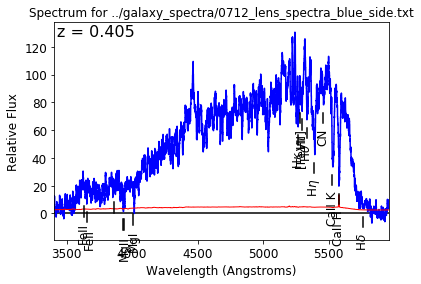

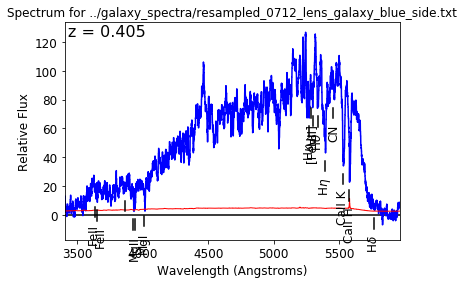

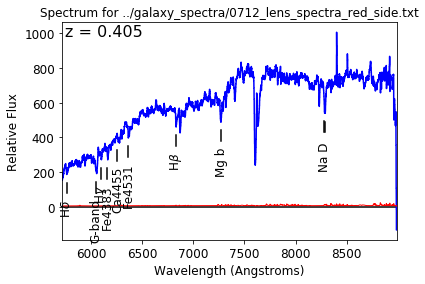

In [3]:
data_blue.smooth(7)
data_blue.mark_lines('abs', z=0.405, usesmooth=True)
data_blue_resmp.smooth(7)
data_blue_resmp.mark_lines('abs', z=0.405, usesmooth=True)
data_red.smooth(7)
data_red.mark_lines('abs', z=0.405, usesmooth=True)

In [4]:
z = 0.405
lam_temp_ini = 3465.0       
lam_temp_fin = 9469.00
lam_range_min = lam_temp_ini*(1+z)
lam_range_max = lam_temp_fin*(1+z)
print(lam_range_min)
print(lam_range_max)

4868.325
13303.945


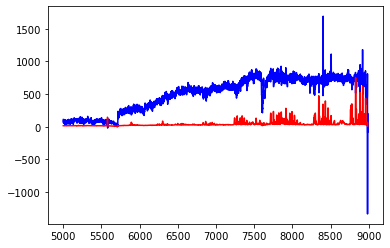

In [5]:
lamda_galaxy = np.asarray(data_blue_resmp['wav'][1997:2891].tolist() + data_red['wav'].tolist())
spectra_galaxy = np.asarray(data_blue_resmp['flux'][1997:2891].tolist() + data_red['flux'].tolist())
variance_spectra_galaxy = np.asarray(data_blue_resmp['var'][1997:2891].tolist() + data_red['var'].tolist())
#sky_spectra_galaxy_red = data_red['sky']
lamda_galaxy_range =  [np.min(lamda_galaxy), np.max(lamda_galaxy)]
#lamda_galaxy.tolist().index(4999.94676193628)
plt.plot(lamda_galaxy, spectra_galaxy, 'b')
#plt.figure()
plt.plot(lamda_galaxy, variance_spectra_galaxy*0.1, 'r')

Velocity scale = 47.961901 km/s
dv = -109948.068401 


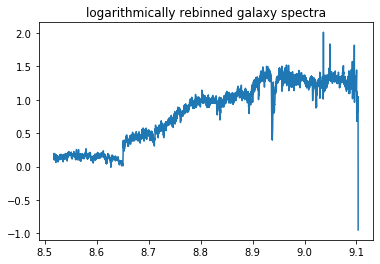

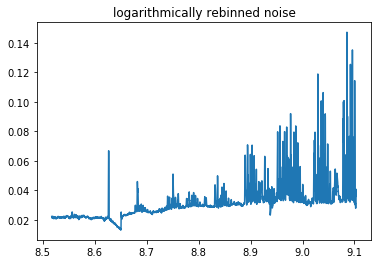

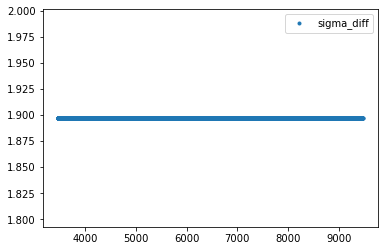

In [6]:
# Calulating velocity scale

velocity_scale = vd.velocity_scale(lamda_galaxy)

# Calculating the parameter 'dv'

dv = vd.wav_dev(lamda_galaxy[0])

# Initial guess for velocity and velocity dispersion

c = 299792.458
vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017)
start = [vel, 200.0]  

# Logarithmically rebinning the galaxy spectra

median_spectra_gal = np.median(spectra_galaxy)       # median of the spectra_galaxy
spectra_galaxy_normalized = spectra_galaxy / median_spectra_gal
spectra_galaxy_rebinned, log_lamda_galaxy, v = util.log_rebin(lamda_galaxy_range, 
                                        spectra_galaxy_normalized, velscale=velocity_scale)
plt.plot(log_lamda_galaxy, spectra_galaxy_rebinned)
plt.title('logarithmically rebinned galaxy spectra')
plt.show()

## Noise

sigma_galaxy_spectra = np.sqrt(variance_spectra_galaxy) 
noise = sigma_galaxy_spectra / median_spectra_gal

#constant_noise = np.full_like(spectra_galaxy_rebinned, 0.02) 
noise_rebinned, log_lamda_noise, velo_scale = util.log_rebin(lamda_galaxy_range, noise,
                                                          velscale=velocity_scale)

plt.plot(log_lamda_noise, noise_rebinned)
plt.title('logarithmically rebinned noise')
#plt.plot(log_lamda_galaxy, spectra_galaxy_rebinned, label='logarithmically rebinned galaxy spectra')
#plt.plot(log_lamda_galaxy, constant_noise, label='constant noise')
#plt.legend()
plt.show()
#print(velo_scale)
#print(np.size(noise_new))


# Calculating the difference in sigma between the instrumental LSF of the galaxy spectra and templates.
# Here sigma of the instrument, 'sig_ins', has been obtained by performing Gaussian fit with several emission 
# lines from the galaxy spectra.

sigma_diff = vd.gen_sigma_diff(sig_ins=1.982, lam_gal=lamda_galaxy)


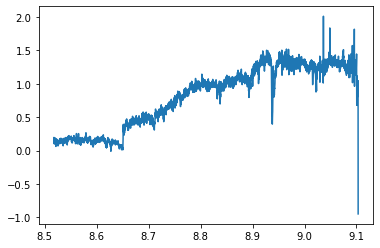

In [7]:
#%matplotlib notebook
plt.plot(log_lamda_galaxy, spectra_galaxy_rebinned)

In [8]:
mask_region = [[(8.6437, 8.6544), (8.8351, 8.83976), (8.9344, 8.9508), (9.03385, 9.03853),
                (9.04731, 9.04993), (9.0919, 9.1035)]]
              #[(8.8351, 8.83976), (8.9344, 8.9808), (9.02787, 9.1035)],
              #[(8.8351, 8.83976), (8.9344, 8.9808), (9.0127, 9.02541), (9.02787, 9.1035)],
              #[(8.8282, 8.84105), (8.9344, 8.9808), (9.0131, 9.02541), (9.02787, 9.1035)], 
              #[(8.7045, 8.7326), (8.8282, 8.84105), (8.9344, 8.9808), (9.0131, 9.02541), (9.02787, 9.1035)]] 
#(8.95506, 8.97243), (8.82944, ), (8.95506, 8.9808), (9.0839, 9.1035) (9.02787, 9.05235),

In [9]:
templates = vd.gen_rebinned_templates(lib_path='../TEXT/*', temp_num=850, sigma_diff=sigma_diff,
                                      v=velocity_scale)

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    102513       357     0.008    -0.003
chi2/DOF: 5.37
method = capfit; Jac calls: 12; Func calls: 68; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  9 / 850
[0.022819163459591025, 0.031130249644025033, 3.1301953486048766e-06, 0.05359639676492677, 0.055512077063482546, 0.12074503819486397, 0.010591721382116004, 0.11220943076044272, 0.016998393329810943, 0.23135250185702963]
degree : 4
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    102529       331     0.006    -0.001
chi2/DOF: 4.989
method = capfit; Jac calls: 10; Func calls: 54; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  8 / 850
[0.15526944208391574, 0.031828962768077965, 0.032956259679616975, 0.03529903722197778, 0.024796863010810532, 0.037463826078466, 0.08895171561082875, 0.2284578445453429]
degree : 5
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    102523       338     0.006    -0.001
chi2/DOF: 4.984
metho

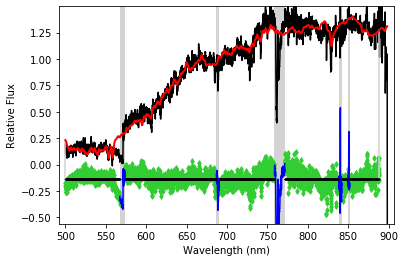

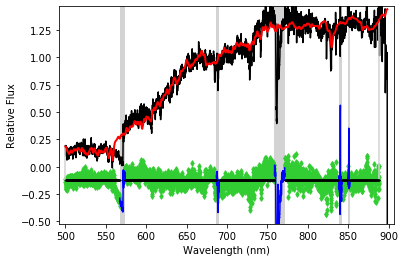

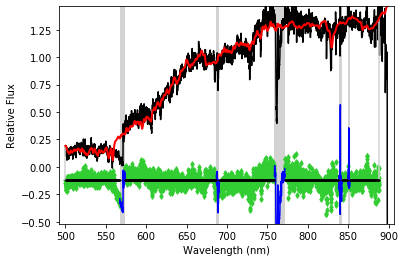

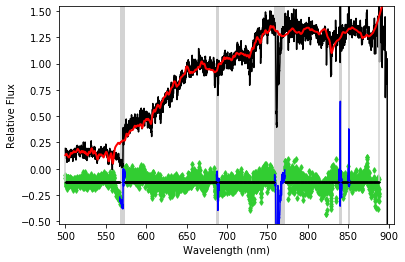

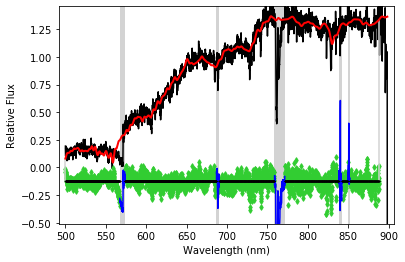

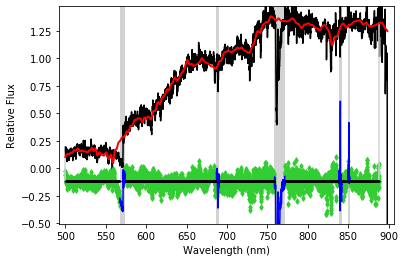

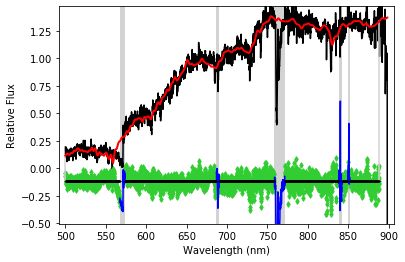

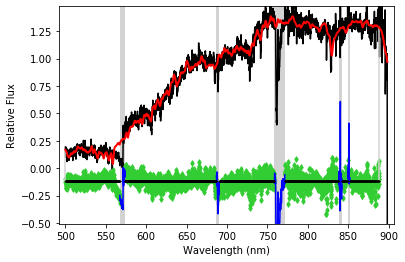

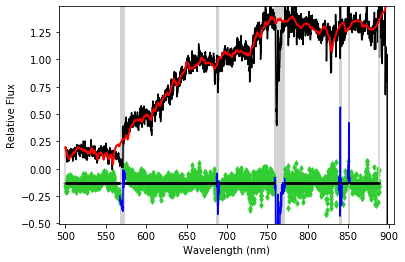

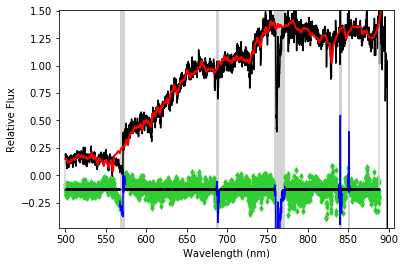

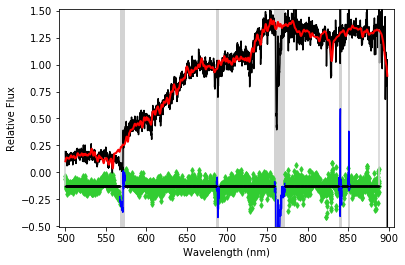

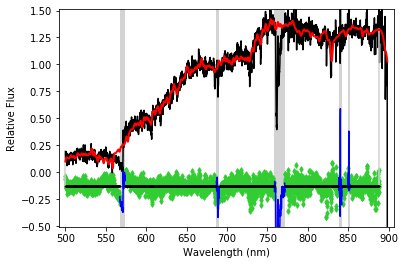

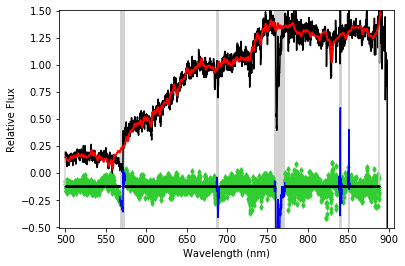

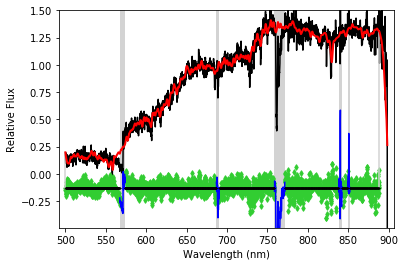

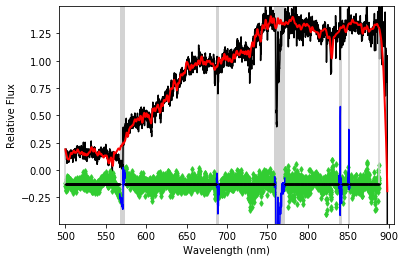

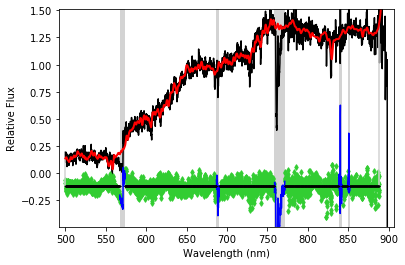

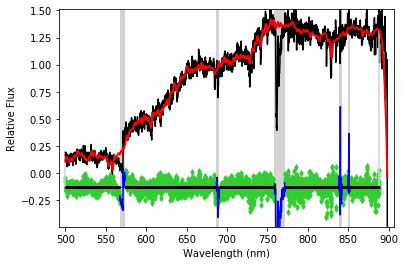

<Figure size 432x288 with 0 Axes>

In [11]:
degree = np.arange(4,21)
velocity_dispersion = np.zeros(len(degree))
error_corrected = np.zeros(len(degree))
error = np.zeros(len(degree))
mask = vd.masking(mask_region[0], log_lamda_galaxy)
for i in range(len(degree)):
    pp = ppxf(templates, spectra_galaxy_rebinned, noise_rebinned, velocity_scale, start, moments=4,
         plot=True, degree=degree[i], vsyst=dv, mask= mask, lam=np.exp(log_lamda_galaxy))
    velocity_dispersion[i] = pp.sol[1]
    error[i] = pp.error[1]
    error_corrected[i] = pp.error[1]*np.sqrt(pp.chi2)
    a = []
    for j, p in enumerate(pp.weights):
        if p > 0 :
            a.append(p)
    print(a)
    plt.figure()
    print('degree : %d' %degree[i])

<Figure size 432x288 with 0 Axes>

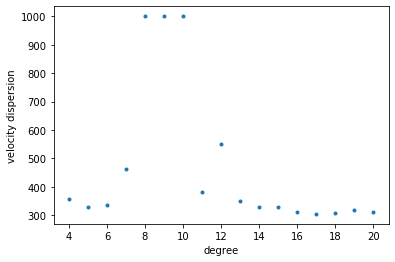

<Figure size 432x288 with 0 Axes>

In [12]:
plt.plot(degree, velocity_dispersion, '.')
plt.xlabel('degree')
plt.ylabel('velocity dispersion')
#plt.title('with mask region 2')
#plt.ylim(280, 400)
plt.figure()

<Figure size 432x288 with 0 Axes>

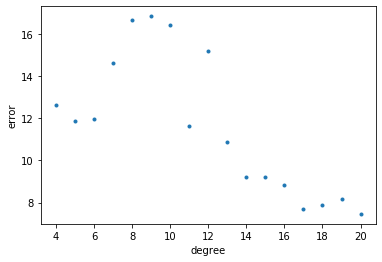

<Figure size 432x288 with 0 Axes>

In [13]:
plt.plot(degree, error, '.')
plt.xlabel('degree')
plt.ylabel('error')
#plt.title('with mask region 2')
#plt.ylim(7, 11)
plt.figure()